In [1]:
import os
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import logging
import time

In [2]:
from datetime import datetime
from PyQt5.QtWidgets import QApplication, QFileDialog
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import firwin, filtfilt
from scipy.io import loadmat

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LeakyReLU

In [4]:
def select_folder():
    app = QApplication([])  
    folder_path = QFileDialog.getExistingDirectory(None, "Select a Folder")
    return folder_path

In [5]:
import time
import logging
import os
import segyio
import numpy as np
import pandas as pd
from datetime import datetime

def seismic_data():
    logging.basicConfig(level=logging.INFO)
    
    folder_path = select_folder()
    if not folder_path:
        print("No folder selected. Exiting.")
        return None
    
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    if not files:
        print("No files found in the selected folder. Exiting.")
        return None

    n_files = len(files)
    
    i_line = 5
    x_line = 21
    dp_x = 73
    dp_y = 77
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d %H:%M:%S")
    
    start_time = time.time()  # Start time

    f = {}
    for i in range(n_files):
        file_name = files[i].split("/")[-1]
        f[i] = segyio.open(files[i])
        logging.info("Input Attributes: " + str(file_name))
        sgs = f[0].header[0][71]
        logging.info("Iline Range: " + str(min(f[i].ilines)) + "-" + str(max(f[i].ilines)) + "(byte: {})".format(i_line))
        logging.info("Xline Range: " + str(min(f[i].xlines)) + "-" + str(max(f[i].xlines)) + "(byte: {})".format(x_line))
        logging.info("Sample Range: " + str(min(f[i].samples)) + "-" + str(max(f[i].samples)))
        
        cdpx = [f[i].header[0][dp_x], f[i].header[-1][dp_x], f[i].header[-(len(f[i].xlines))][dp_x],
                f[i].header[len(f[i].xlines) - 1][dp_x]]
        cdpy = [f[i].header[0][dp_y], f[i].header[-1][dp_y], f[i].header[-(len(f[i].xlines))][dp_y],
                f[i].header[len(f[i].xlines) - 1][dp_y]]
        iline_cood = [f[i].header[0][i_line], f[i].header[-1][i_line], f[i].header[-(len(f[i].xlines))][i_line],
                      f[i].header[len(f[i].xlines) - 1][i_line]]
        xline_cood = [f[i].header[0][x_line], f[i].header[-1][x_line], f[i].header[-(len(f[i].xlines))][x_line],
                      f[i].header[len(f[i].xlines) - 1][x_line]]
        
        len1 = (((cdpx[0] - cdpx[3]) ** 2) + ((cdpy[0] - cdpy[3]) ** 2)) ** (1 / 2)
        len2 = (((cdpx[0] - cdpx[2]) ** 2) + ((cdpy[0] - cdpy[2]) ** 2)) ** (1 / 2)
        
        deg_1 = np.angle(complex((cdpx[3] - cdpx[0]), (cdpy[3] - cdpy[0])), deg=True)
        if (deg_1 < 0):
            fin_deg = 270 + deg_1
        elif (deg_1 >= 0) and (deg_1 <= 90):
            fin_deg = 90 - deg_1
        else:
            fin_deg = 450 - deg_1
        logging.info("SGS: " + str(sgs))
        logging.info("X Range: " + str(min(cdpx)) + "-" + str(max(cdpx)))
        logging.info("Y Range: " + str(min(cdpy)) + "-" + str(max(cdpy)))
        
    sgs = f[0].header[0][71]
    iline = [1835, 2475]
    xline = [5305, 5665]
    samples = [5620, 5860]

    skip = 0  # inlines and xlines have been skipped to optimize available infrastructure
    w = skip + 1  # To be added in the widget, either skip= 0 or 1

    min_depth = min(f[0].samples)
    max_depth = max(f[0].samples)
    depth_interval = f[0].samples[1] - f[0].samples[0]
    min_xlines = min(f[0].xlines)
    max_xlines = max(f[0].xlines)
    min_ilines = min(f[0].ilines)
    max_ilines = max(f[0].ilines)
    samples_l = int(samples[0])
    samples_u = int(samples[1])
    depth = int(((samples_u - samples_l) / depth_interval) + 1)
    a1 = int((samples[0] - min(f[0].samples)) / depth_interval)
    b1 = int((samples[1] - min(f[0].samples)) / depth_interval) + 1

    ilines = round(((iline[1] - iline[0]) + 1) / w)
    xlines = round(((xline[1] - xline[0]) + 1) / w)

    plane = []
    for il in range(iline[0], iline[1] + 1, w):
        for xl in range(xline[0], xline[1] + 1, w):
            ie = (il - min_ilines) * len(f[0].xlines) + (xl - min_xlines)
            plane.append(ie)

    final_values2 = np.empty([5 + n_files, xlines * ilines * depth], dtype=np.float32)
    x = [f[0].header[i][i_line] for i in plane]
    x1 = [np.repeat(i, depth) for i in x]
    final_values2[0] = np.reshape(x1, (xlines * ilines * depth,))

    y = [f[0].header[i][x_line] for i in plane]
    y1 = [np.repeat(i, depth) for i in y]
    final_values2[1] = np.reshape(y1, (xlines * ilines * depth,))
    del y1
    del y

    final_values2[4] = np.tile(f[0].samples[a1:b1], xlines * ilines)

    cdpx = [f[0].header[i][dp_x] for i in plane]
    cdpx1 = [np.repeat(i, depth) for i in cdpx]
    final_values2[2] = np.reshape(cdpx1, (xlines * ilines * depth,))
    del cdpx1
    del cdpx

    cdpy = [f[0].header[i][dp_y] for i in plane]
    cdpy1 = [np.repeat(i, depth) for i in cdpy]
    final_values2[3] = np.reshape(cdpy1, (xlines * ilines * depth,))
    del cdpy1
    del cdpy

    v = {}
    for attr in range(n_files):
        v[attr] = [f[attr].trace[i][a1:b1] for i in plane]
        v[attr] = np.reshape(v[attr], (xlines * ilines * depth,))
        final_values2[attr + 5] = v[attr]
    del v

    final_values2 = final_values2.T

    array_index = np.array([i for i in range(len(final_values2))]).reshape(final_values2.shape[0], 1)
    final_values2 = np.concatenate((array_index, final_values2), axis=1)

    del array_index

    df_s = pd.DataFrame(final_values2).rename(columns={0: 'index', 1: 'inline', 2: 'xline', 3: 'X', 4: 'Y', 5: 'TWT', 6: 'Env', 7: 'LFI', 8: 'LR', 9: 'MR', 10: 'PR', 11: 'VPVS', 12:'ZP', 13:'Sweetness'})
    df_s["X"] = df_s.X / 100
    df_s["Y"] = df_s.Y / 100
    
    end_time = time.time()  # End time
    execution_time = end_time - start_time  # Calculate execution time
    print(f"Execution Time: {execution_time:.2f} seconds")

    return df_s

if __name__ == "__main__":
    df_s = seismic_data()
    if df_s is not None:
        display(df_s)


INFO:root:Input Attributes: Seismic_Attrifusion\Envolop_IL1835_IL2475 _XL5305_XL5665.sgy
INFO:root:Iline Range: 1835-2475(byte: 5)
INFO:root:Xline Range: 5305-5665(byte: 21)
INFO:root:Sample Range: 5620.0-5860.0
INFO:root:SGS: -100
INFO:root:X Range: 78096268-79072800
INFO:root:Y Range: 874619639-875887100
INFO:root:Input Attributes: Seismic_Attrifusion\LFI_IL1835_IL2475 _XL5305_XL5665.sgy
INFO:root:Iline Range: 1835-2475(byte: 5)
INFO:root:Xline Range: 5305-5665(byte: 21)
INFO:root:Sample Range: 5620.0-5860.0
INFO:root:SGS: -100
INFO:root:X Range: 78096268-79072800
INFO:root:Y Range: 874619639-875887100
INFO:root:Input Attributes: Seismic_Attrifusion\LR_IL1835_IL2475 _XL5305_XL5665.sgy
INFO:root:Iline Range: 1835-2475(byte: 5)
INFO:root:Xline Range: 5305-5665(byte: 21)
INFO:root:Sample Range: 5620.0-5860.0
INFO:root:SGS: -100
INFO:root:X Range: 78096268-79072800
INFO:root:Y Range: 874619639-875887100
INFO:root:Input Attributes: Seismic_Attrifusion\MR_IL1835_IL2475 _XL5305_XL5665.sgy
I

Execution Time: 27.96 seconds


,index,inline,xline,X,Y,TWT,Env,LFI,LR,MR,PR,VPVS,ZP,Sweetness
0,0.0,1835.0,5305.0,784895.44,8746196.48,5620.0,14931.391602,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1835.0,5305.0,784895.44,8746196.48,5624.0,9822.913086,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1835.0,5305.0,784895.44,8746196.48,5628.0,8046.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1835.0,5305.0,784895.44,8746196.48,5632.0,2572.332764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1835.0,5305.0,784895.44,8746196.48,5636.0,9715.355469,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14115456,14115456.0,2475.0,5665.0,786795.20,8758871.04,5844.0,34306.816406,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115457,14115457.0,2475.0,5665.0,786795.20,8758871.04,5848.0,37282.238281,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115458,14115458.0,2475.0,5665.0,786795.20,8758871.04,5852.0,35743.261719,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115459,14115459.0,2475.0,5665.0,786795.20,8758871.04,5856.0,29610.474609,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df=df_s[df_s!=0].dropna()

Reading WELL LOGS

In [7]:
import os
import pandas as pd
import lasio

def well_data(folder_path):
    df_well_og = pd.DataFrame()
    files = os.listdir(folder_path)
#     display(files)

    df_1 = pd.DataFrame()
    for file_name in files:
        las = lasio.read(os.path.join(folder_path, file_name))
        las = las.df()
        las = las.reset_index()
        well_name = file_name.split('.')[0]  
        las['WELL'] = well_name 
        df_1 = pd.concat([df_1, las])
       
    df_1=df_1[['DEPT','CALI', 'DTC', 'GR', 'NPHI', 'RHOB', 'RESD', 'DTS', 'VP', 'PHIE', 'PHIT', 'VSH', 'SWE','WELL']]
    df_1=df_1.rename(columns={"DEPT":'MD'})
    df_1=df_1.dropna()
    return df_1


if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            df_well_og = well_data(folder_path)
            display(df_well_og)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

INFO:lasio.reader:Opening C:/Users/Administrator/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\MB-2 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/Administrator/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\MB-9 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/Administrator/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\SES-168 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/Administrator/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\SES-178 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have 

,MD,CALI,DTC,GR,NPHI,RHOB,RESD,DTS,VP,PHIE,PHIT,VSH,SWE,WELL
6662,4865.2886,12.160100,95.624100,115.486900,0.3112,2.5459,1.5359,187.273605,3187.480957,0.000034,0.110021,0.956844,1.0,MB-2
6663,4865.4414,12.162299,95.563202,119.651802,0.3051,2.5433,1.5596,189.149704,3189.512207,0.020652,0.123079,0.931161,1.0,MB-2
6664,4865.5938,12.160500,95.200897,123.225800,0.3016,2.5346,1.5875,190.587997,3201.650391,0.029587,0.128739,0.901423,1.0,MB-2
6665,4865.7461,12.151001,94.397697,123.338097,0.3139,2.5234,1.6057,189.029602,3228.892334,0.024386,0.125444,0.918736,1.0,MB-2
6666,4865.8984,12.160999,93.338303,119.936996,0.3336,2.5182,1.6159,186.083099,3265.540527,0.000000,0.110000,0.973100,1.0,MB-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5441,5379.2085,12.469601,66.114998,72.226799,7.9688,2.6232,14.2298,119.712997,4610.148926,0.002688,0.045428,0.388525,1.0,SES-189
5442,5379.3608,12.467500,71.449196,62.870300,7.9316,2.6401,15.8231,133.636307,4265.968262,0.000000,0.046899,0.426400,1.0,SES-189
5443,5379.5132,12.471300,75.536400,52.378101,9.6146,2.6550,17.9671,143.894302,4035.140625,0.000000,0.057492,0.522700,1.0,SES-189
5444,5379.6655,12.494300,78.029404,50.074501,11.1458,2.6485,19.4835,148.505493,3906.219727,0.000000,0.062010,0.563773,1.0,SES-189


In [8]:
#pip install lasio

Read TDR 

In [9]:
import os
import pandas as pd

def tdr_data(folder_path, skip_rows):
    df_tdr = pd.DataFrame()

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                dataframe1 = pd.read_csv(file, skiprows=skip_rows, header=None, sep="\s+|\t")
                dataframe1['Well name'] = filename.split("_")[0]
                df_tdr = df_tdr.append(dataframe1, ignore_index=True)
        
#     df_tdr = df_tdr.rename(columns={0: 'MD', 1: "TVD", 2:"TVDSS", 3:"TWT", 4:"Vint"}) #MD(m)TVD(m)TVDSS(m)TWT(ms)Vint(m/s)
    df_tdr = df_tdr.rename(columns={0: 'MD', 1: "TWT"}) #Aakash_modified_as_input_data_mismatched

    
    df_tdr = df_tdr[df_tdr != -999.2500]
    df_tdr = df_tdr.dropna()
    df_tdr = df_tdr.reset_index(drop=True)
    
    return df_tdr

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 1 row")
            skip_rows = int(input("Enter the number of rows to skip: "))
            
            df_tdr = tdr_data(folder_path, skip_rows)
            display(df_tdr)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

OVL skip 1 row
Enter the number of rows to skip: 1


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\1697014787.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe1 = pd.read_csv(file, skiprows=skip_rows, header=None, sep="\s+|\t")
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\1697014787.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tdr = df_tdr.append(dataframe1, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\1697014787.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe1 = pd.read_cs

,MD,TWT,Well name
0,25.0,0.0000,MB-2
1,3905.0,4708.0625,MB-2
2,3907.0,4710.2075,MB-2
3,3909.0,4711.8198,MB-2
4,3911.0,4713.3564,MB-2
...,...,...,...
6652,5514.0,5654.2402,SES-189
6653,5516.0,5655.6133,SES-189
6654,5518.0,5656.9858,SES-189
6655,5520.0,5658.3589,SES-189


Read MD. X CO-ORD, Y CO-ORD from the deviation survey 

In [10]:
def dev_data(folder_path,skip_rows):
    df_dev = pd.DataFrame()

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            df=pd.read_csv(file,skiprows=skip_rows,header=None,sep=" ")

            df=df.iloc[:,0:4]
            df['Well name']=filename
            df_dev=df_dev.append(df)
    df_dev=df_dev.drop(columns=0)
    df_dev=df_dev.rename(columns={1:'MD',2:'X',3:'Y'})
    df_dev=df_dev.dropna()
    return df_dev

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 18 row")
            skip_rows=int(input("Enter the number of rows to skip :"))
            df_dev = dev_data(folder_path,skip_rows)
            display(df_dev)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")


OVL skip 18 row
Enter the number of rows to skip :18


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\3996867302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dev=df_dev.append(df)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\3996867302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dev=df_dev.append(df)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\3996867302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dev=df_dev.append(df)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\3996867302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dev=df_dev.append(df)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_96

,MD,X,Y,Well name
0,0.0,782939.00000,8.755838e+06,MB-2
1,2654.0,782939.00000,8.755838e+06,MB-2
2,2795.0,782939.05451,8.755838e+06,MB-2
3,2875.0,782939.11478,8.755837e+06,MB-2
4,2914.0,782939.12211,8.755837e+06,MB-2
...,...,...,...,...
40,5187.0,776107.47859,8.732746e+06,SES-191
41,5230.0,776107.29803,8.732745e+06,SES-191
42,5308.0,776107.02080,8.732743e+06,SES-191
43,5343.0,776106.96690,8.732742e+06,SES-191


In [11]:
df_well=df_well_og.copy()

In [12]:
df_tdr

,MD,TWT,Well name
0,25.0,0.0000,MB-2
1,3905.0,4708.0625,MB-2
2,3907.0,4710.2075,MB-2
3,3909.0,4711.8198,MB-2
4,3911.0,4713.3564,MB-2
...,...,...,...
6652,5514.0,5654.2402,SES-189
6653,5516.0,5655.6133,SES-189
6654,5518.0,5656.9858,SES-189
6655,5520.0,5658.3589,SES-189


In [13]:
def update_well_twt(df_well, df_tdr):
    dfm = pd.DataFrame()
    for well_name in df_tdr['Well name'].unique():
        df_ms = df_well[df_well['WELL'] == well_name]
        df_n = df_tdr[df_tdr['Well name'] == well_name]
        
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['TWT']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['TWT']] = X_Y
        dfm = pd.concat([dfm, df_ms], ignore_index=True)
    return dfm

In [14]:
# if 'TWT' in df_well.columns:
    # Your code to access the column here
#     pass
# else:
#     print("Column 'TWT' not found after stripping spaces.")

In [15]:
# pd.read_csv('source.txt',header=0, delim_whitespace=True)

In [16]:
dfm = update_well_twt(df_well, df_tdr)

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\4046512853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms[['TWT']] = X_Y
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\4046512853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms[['TWT']] = X_Y
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\4046512853.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [17]:
def update_well_coordinates(dfm, df_dev):
    dfg = pd.DataFrame()
    for well_name in dfm['WELL'].unique():
        df_ms = dfm[dfm['WELL'] == well_name]
        df_n = df_dev[df_dev['Well name'] == well_name]
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['X', 'Y']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['X', 'Y']] = X_Y
        dfg = pd.concat([dfg, df_ms], ignore_index=True)
    return dfg

In [18]:
dfg=update_well_coordinates(dfm, df_dev)
dfg

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\2500573320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms[['X', 'Y']] = X_Y
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\2500573320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms[['X', 'Y']] = X_Y
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\2500573320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,MD,CALI,DTC,GR,NPHI,RHOB,RESD,DTS,VP,PHIE,PHIT,VSH,SWE,WELL,TWT,X,Y
0,4865.2886,12.160100,95.624100,115.486900,0.3112,2.5459,1.5359,187.273605,3187.480957,0.000034,0.110021,0.956844,1.0,MB-2,5387.3789,782936.52816,8.755825e+06
1,4865.4414,12.162299,95.563202,119.651802,0.3051,2.5433,1.5596,189.149704,3189.512207,0.020652,0.123079,0.931161,1.0,MB-2,5387.3789,782936.52816,8.755825e+06
2,4865.5938,12.160500,95.200897,123.225800,0.3016,2.5346,1.5875,190.587997,3201.650391,0.029587,0.128739,0.901423,1.0,MB-2,5387.3789,782936.52816,8.755825e+06
3,4865.7461,12.151001,94.397697,123.338097,0.3139,2.5234,1.6057,189.029602,3228.892334,0.024386,0.125444,0.918736,1.0,MB-2,5387.3789,782936.52816,8.755825e+06
4,4865.8984,12.160999,93.338303,119.936996,0.3336,2.5182,1.6159,186.083099,3265.540527,0.000000,0.110000,0.973100,1.0,MB-2,5387.3789,782936.52816,8.755825e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20415,5379.2085,12.469601,66.114998,72.226799,7.9688,2.6232,14.2298,119.712997,4610.148926,0.002688,0.045428,0.388525,1.0,SES-189,5566.8013,773339.66067,8.754838e+06
20416,5379.3608,12.467500,71.449196,62.870300,7.9316,2.6401,15.8231,133.636307,4265.968262,0.000000,0.046899,0.426400,1.0,SES-189,5566.8013,773339.66067,8.754838e+06
20417,5379.5132,12.471300,75.536400,52.378101,9.6146,2.6550,17.9671,143.894302,4035.140625,0.000000,0.057492,0.522700,1.0,SES-189,5566.8013,773339.66067,8.754838e+06
20418,5379.6655,12.494300,78.029404,50.074501,11.1458,2.6485,19.4835,148.505493,3906.219727,0.000000,0.062010,0.563773,1.0,SES-189,5566.8013,773339.66067,8.754838e+06


In [19]:
df.columns

Index(['index', 'inline', 'xline', 'X', 'Y', 'TWT', 'Env', 'LFI', 'LR', 'MR',
       'PR', 'VPVS', 'ZP', 'Sweetness'],
      dtype='object')

In [20]:
import time
from sklearn.neighbors import KNeighborsRegressor

def seismic_trace(train_df, test_df, feature_cols, target_cols, n_neighbors=1):
    start_time = time.time()  # Start time measurement

    x_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    x_test = test_df[feature_cols]
    
    # Initialize and fit the KNN regressor
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    
    # Predict
    predictions = knn.predict(x_test)
    
    # Create the result dataframe with predictions
    result_df = test_df.copy()
    result_df[target_cols] = predictions
    
    end_time = time.time()  # End time measurement
    
    # Calculate execution time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.4f} seconds")

    return result_df

# Example usage:
dfg = seismic_trace(df, dfg, ['TWT', 'X', 'Y'], ['Env', 'LFI', 'LR', 'MR',
       'PR', 'VPVS', 'ZP', 'Sweetness'])

Execution time: 12.4192 seconds


In [21]:
wdfs6=dfg.copy()

Drop the wells that are not drilled in the seismic survey area.

In [22]:
wdfs6 = wdfs6[~wdfs6['WELL'].isin(['SES-181', 'SES-184'])]

Select the Logs (Reservoir property) to upscale at seismic frequency level

In [23]:
wdfs6_SW=wdfs6[['MD',  'PHIE', 'WELL']]

Enter Filter Order (n): 40
Enter Cutoff Frequency (m): 0.040


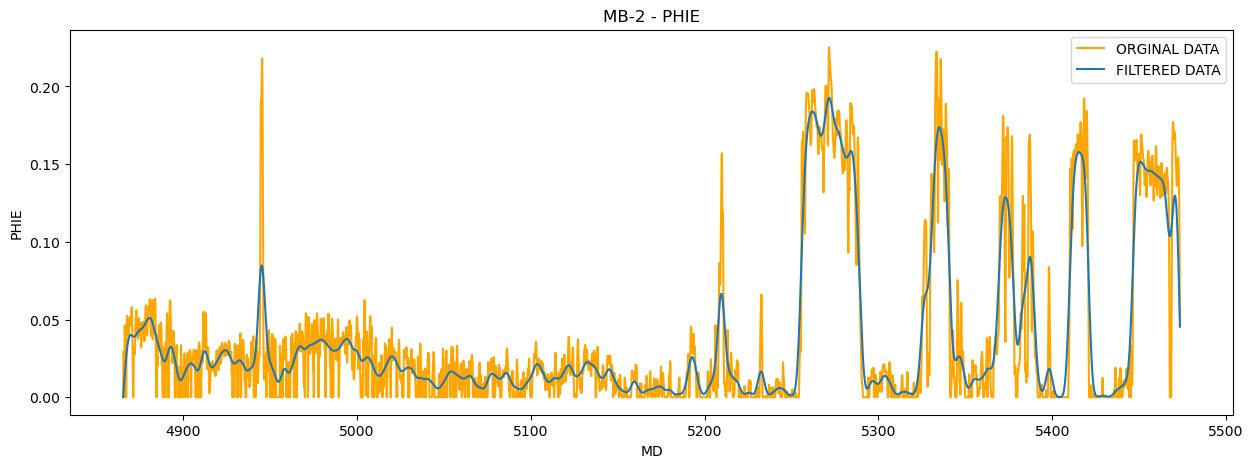

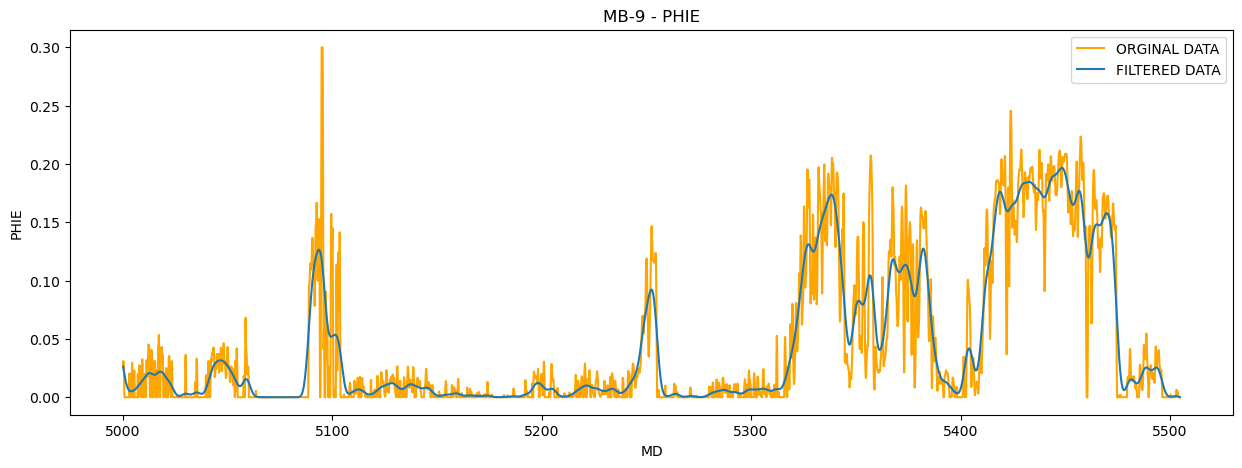

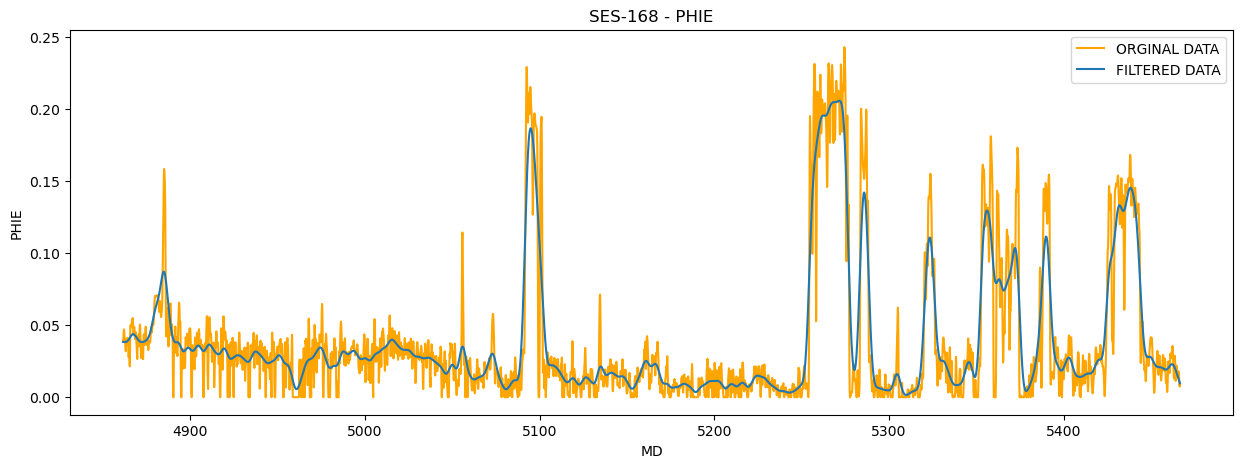

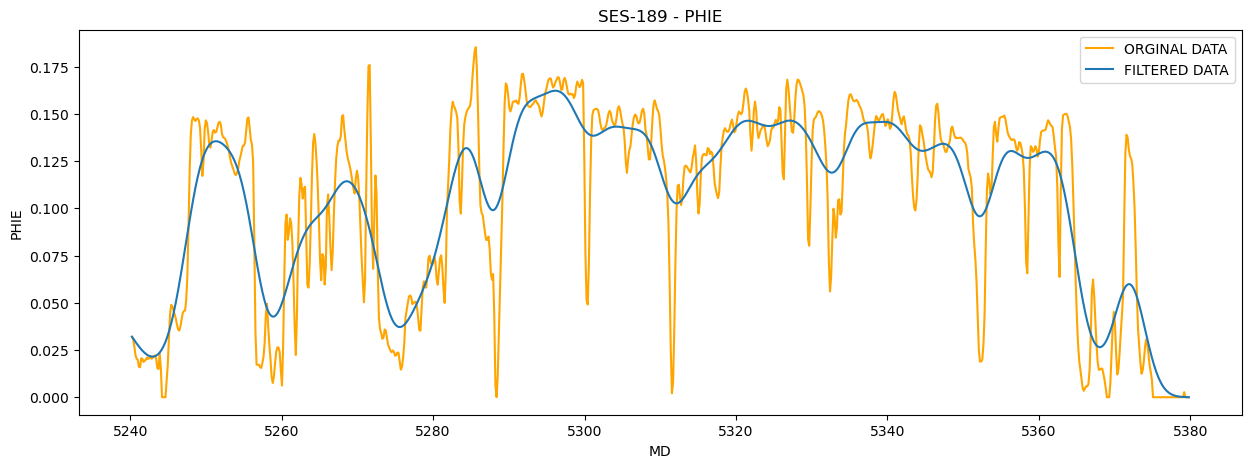

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt
 
def filter_all_wells(wdfs6_SW, n, m):
    filtered_data = pd.DataFrame()
    for well in wdfs6_SW['WELL'].unique():
        dfff = wdfs6_SW[wdfs6_SW['WELL'] == well]
        well_filtered = {'WELL': well, 'MD': dfff['MD'].values}
        for feature in dfff.columns:
            if feature in ['WELL', 'MD']:  # to skip 'WELL' and 'MD'
                continue
            data = dfff[feature].values
            if len(data) < n:
                print(f"Filter order 'n' is greater than the length of the data for well {well} and feature {feature}.")
                continue
            dt = (dfff['MD'].values[1] - dfff['MD'].values[0]).round(4)  
            fNQ = 1 / dt / 2
            if m <= 0 or m >= fNQ:
                print(f"Cutoff frequency 'm' must be between 0 and the Nyquist frequency for well {well} and feature {feature}.")
                continue
            Wn = m / fNQ
            b = firwin(n, Wn)
            filtered_values = filtfilt(b, 1, data)
            well_filtered[feature] = filtered_values
#             well_filtered[feature + '_filtered'] = filtered_values
            
        filt=pd.DataFrame(well_filtered)
        filt=filt.sort_values(by='MD')
#         display(filt)

        for feature in filt.columns:
            if f"{well}_" in feature or feature in ['MD', 'WELL']:
                continue
            plt.figure(figsize=(15, 5))
            plt.plot(dfff['MD'], dfff[feature], color='orange', label='ORGINAL DATA')
            plt.plot(filt['MD'], filt[feature], label="FILTERED DATA")
            plt.xlabel('MD')
            plt.ylabel(feature)
            plt.title(f'{well} - {feature}')
            plt.legend()
            plt.show()
            
        filtered_data = pd.concat([filtered_data, filt], ignore_index=True)
    return filtered_data

n = int(input("Enter Filter Order (n): "))
m = float(input("Enter Cutoff Frequency (m): "))
df_well = filter_all_wells(wdfs6_SW, n, m)
# display(filtered_data)

In [25]:
wdfs6_1=wdfs6[['WELL','MD', 'TWT', 'X', 'Y', 'Env', 'LFI', 'LR', 'MR',
       'PR', 'VPVS', 'ZP', 'Sweetness']]

In [26]:
wdfs6.columns

Index(['MD', 'CALI', 'DTC', 'GR', 'NPHI', 'RHOB', 'RESD', 'DTS', 'VP', 'PHIE',
       'PHIT', 'VSH', 'SWE', 'WELL', 'TWT', 'X', 'Y', 'Env', 'LFI', 'LR', 'MR',
       'PR', 'VPVS', 'ZP', 'Sweetness'],
      dtype='object')

In [27]:
# Set both WELL and MD as index for both dataframes to align them
df_well_set = df_well.set_index(['WELL', 'MD'])
wdfs6_set = wdfs6_1.set_index(['WELL', 'MD'])

# Concatenate along columns (axis=1) based on WELL and MD indices
concatenated_df = pd.concat([df_well_set, wdfs6_set], axis=1, join='inner').reset_index()

In [28]:
concatenated_df

,WELL,MD,PHIE,TWT,X,Y,Env,LFI,LR,MR,PR,VPVS,ZP,Sweetness
0,MB-2,4865.2886,3.380580e-05,5387.3789,782936.52816,8.755825e+06,11125.666016,2879.655029,35.404118,19.675528,0.321399,2926.955322,1.948957,8643.160156
1,MB-2,4865.4414,2.505951e-03,5387.3789,782936.52816,8.755825e+06,11125.666016,2879.655029,35.404118,19.675528,0.321399,2926.955322,1.948957,8643.160156
2,MB-2,4865.5938,4.966922e-03,5387.3789,782936.52816,8.755825e+06,11125.666016,2879.655029,35.404118,19.675528,0.321399,2926.955322,1.948957,8643.160156
3,MB-2,4865.7461,7.405515e-03,5387.3789,782936.52816,8.755825e+06,11125.666016,2879.655029,35.404118,19.675528,0.321399,2926.955322,1.948957,8643.160156
4,MB-2,4865.8984,9.810901e-03,5387.3789,782936.52816,8.755825e+06,11125.666016,2879.655029,35.404118,19.675528,0.321399,2926.955322,1.948957,8643.160156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12185,SES-189,5379.2085,9.898734e-05,5566.8013,773339.66067,8.754838e+06,15152.537109,2702.130127,33.226818,21.534176,0.303384,5241.919922,1.882305,8734.504883
12186,SES-189,5379.3608,6.882410e-05,5566.8013,773339.66067,8.754838e+06,15152.537109,2702.130127,33.226818,21.534176,0.303384,5241.919922,1.882305,8734.504883
12187,SES-189,5379.5132,4.336325e-05,5566.8013,773339.66067,8.754838e+06,15152.537109,2702.130127,33.226818,21.534176,0.303384,5241.919922,1.882305,8734.504883
12188,SES-189,5379.6655,2.094001e-05,5566.8013,773339.66067,8.754838e+06,15152.537109,2702.130127,33.226818,21.534176,0.303384,5241.919922,1.882305,8734.504883


Manual adjustment of depth ranges applied to constrain the depth analysis window across all available wells.

In [29]:
# Step 2: Apply depth constraints for each well (with TWT ranges)
def constrain_depth(row):
    if row['WELL'] == 'MB-2':
        # Set the TWT range for 'MB-2'
        return 5600 <= row['TWT'] <= 5650
    elif row['WELL'] == 'MB-9':
        # Set the TWT range for 'MB-9'
        return 5675 <= row['TWT'] <= 5680
    elif row['WELL'] == 'SES-168':
        # Set the TWT range for 'SES-168'
        return 5700 <= row['TWT'] <= 5745
    # Uncomment and modify this block if needed
    elif row['WELL'] == 'SES-189':
        return 5550 <= row['TWT'] <= 5600
    return True  # Default case, should not be reached if the well is valid, should not be reached if the well is valid

# Apply the depth constraints to filter the dataframe
df_c = concatenated_df[concatenated_df.apply(constrain_depth, axis=1)]

In [30]:
df_c.columns

Index(['WELL', 'MD', 'PHIE', 'TWT', 'X', 'Y', 'Env', 'LFI', 'LR', 'MR', 'PR',
       'VPVS', 'ZP', 'Sweetness'],
      dtype='object')

In [31]:
df_c['WELL'].unique()

array(['MB-2', 'MB-9', 'SES-168', 'SES-189'], dtype=object)

In [32]:
columns=df_c[[ 'PHIE', 'Env', 'LFI', 'LR', 'MR', 'PR',
       'VPVS', 'ZP', 'Sweetness']]

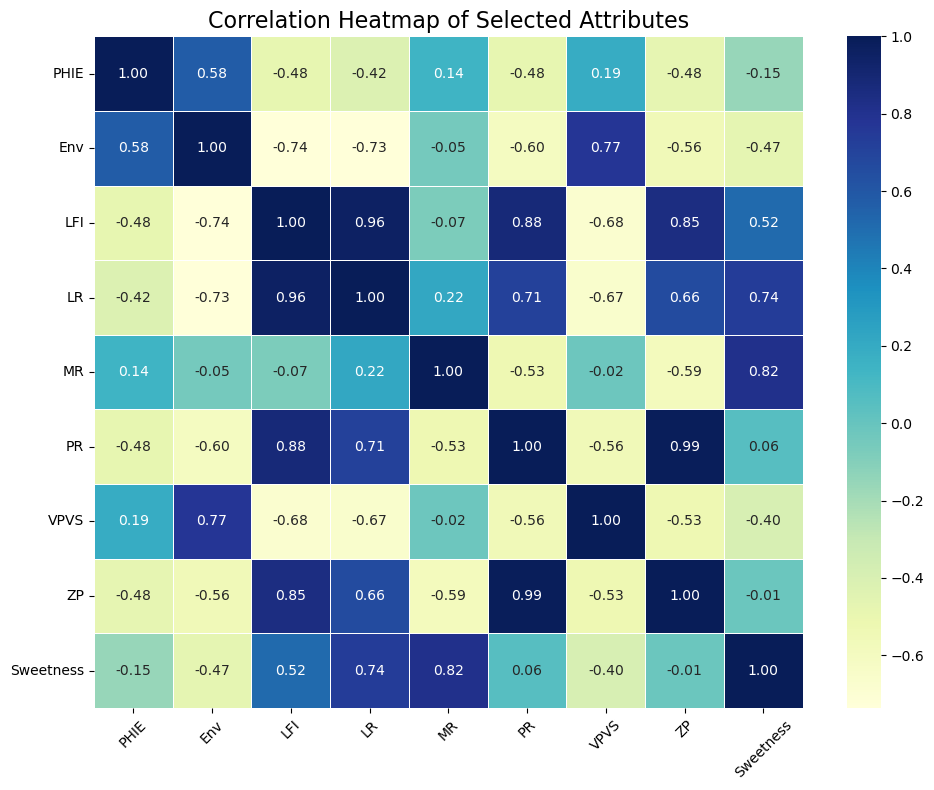

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns to analyze
columns = ['PHIE', 'Env', 'LFI', 'LR', 'MR', 'PR', 'VPVS', 'ZP', 'Sweetness']

# Filter the DataFrame
df_corr = df_c[columns]

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap of Selected Attributes', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [34]:
df_c.columns

Index(['WELL', 'MD', 'PHIE', 'TWT', 'X', 'Y', 'Env', 'LFI', 'LR', 'MR', 'PR',
       'VPVS', 'ZP', 'Sweetness'],
      dtype='object')

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Features with correlation higher than 0.7 or lower than -0.7 with PHIE:
Env_original: 0.5770
Env_sqrt: 0.5738
Env_square: 0.5637
Env_log_square: 0.5631
Env_log: 0.5590
Env_sqrt_log: 0.5568


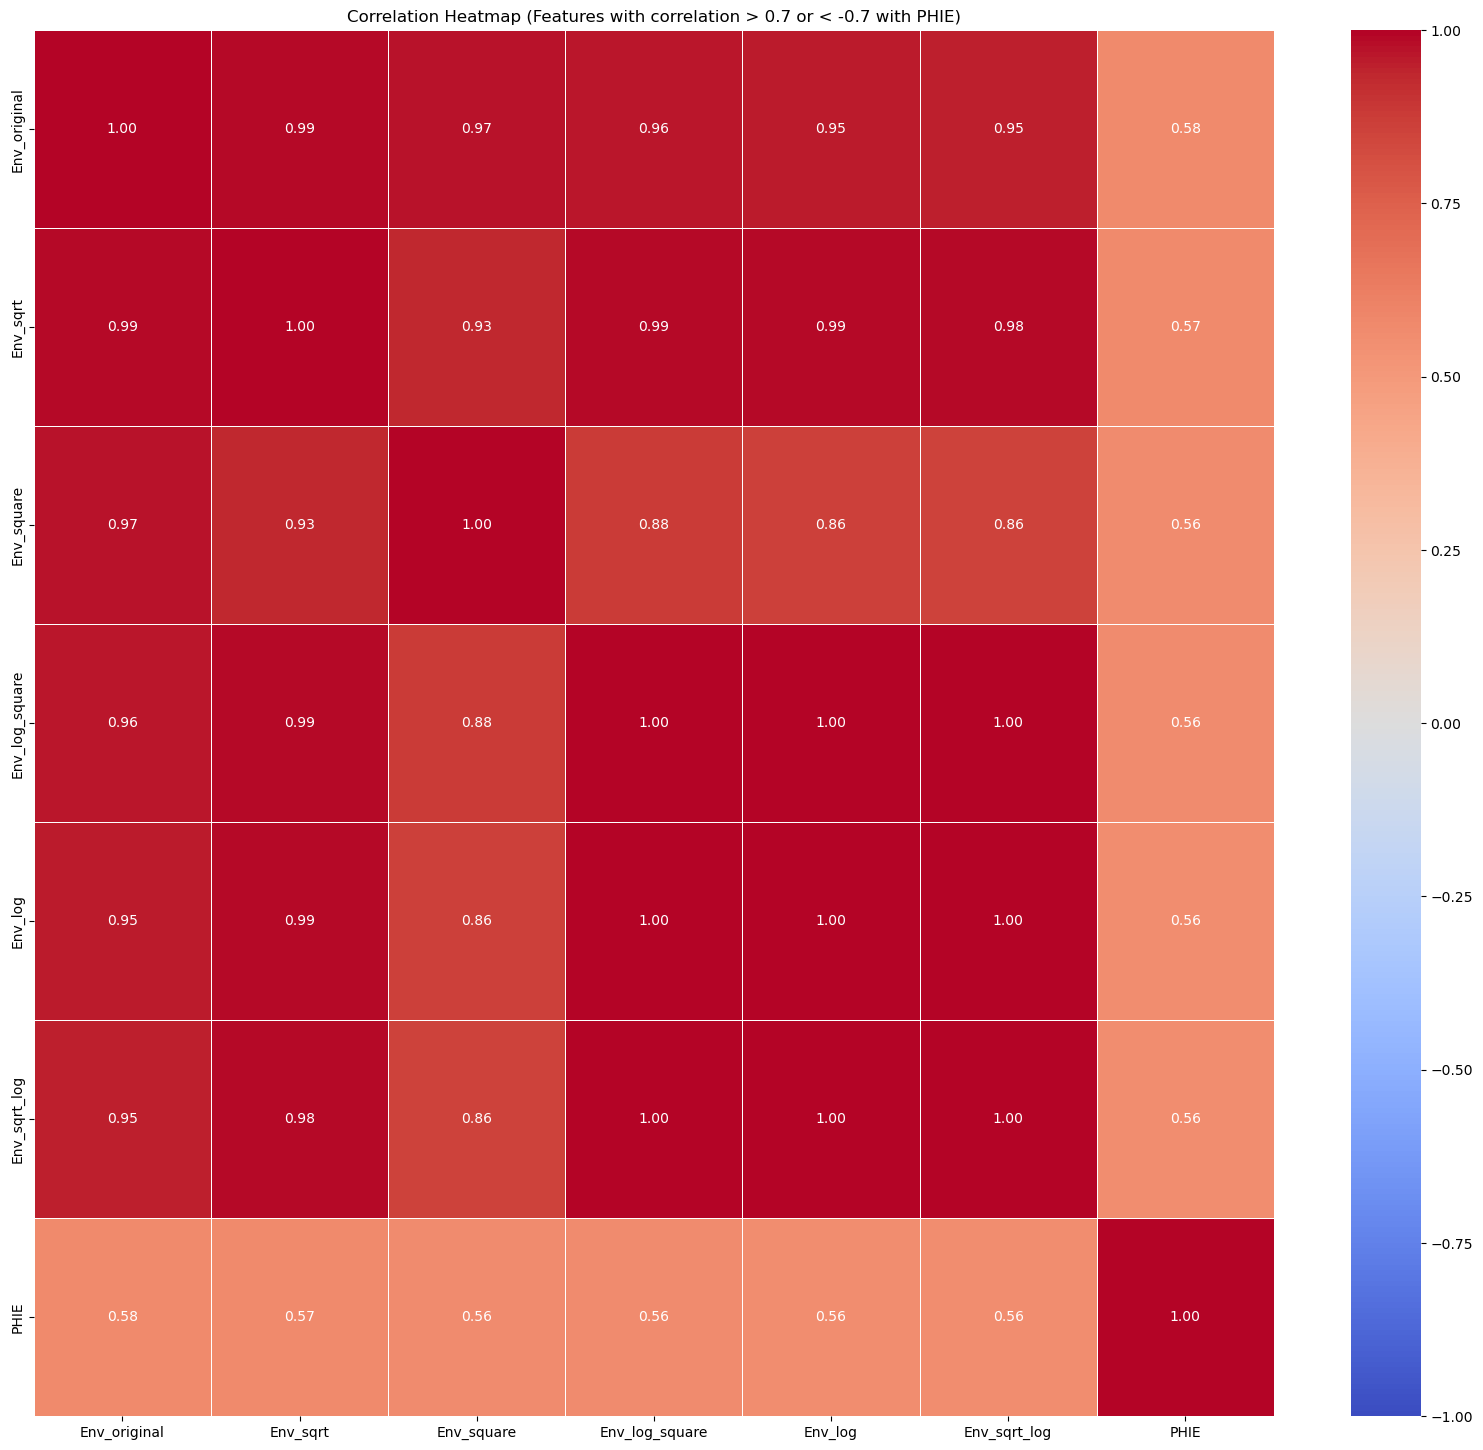

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Function to apply transformations to each feature
def apply_transformations(df, features):
    transformed_data = {}
    
    for feature in features:
        # Skip if the feature has missing values
        if df[feature].isnull().any():
            continue

        # Original feature
        transformed_data[f'{feature}_original'] = df[feature]
        
        # Square root transformation
        transformed_data[f'{feature}_sqrt'] = np.sqrt(df[feature].clip(lower=0))  # Avoid sqrt of negative values
        
        # Logarithmic transformation (add a small value to avoid log(0) or negative values)
        transformed_data[f'{feature}_log'] = np.log(df[feature].clip(lower=1e-5))
        
        # Inverse transformation
        transformed_data[f'{feature}_inverse'] = 1 / (df[feature].replace(0, np.nan))  # Avoid division by zero
        
        # Inverse square transformation
        transformed_data[f'{feature}_inv_sq'] = 1 / (df[feature] ** 2).replace(0, np.nan)  # Avoid division by zero
        
        # Square transformation
        transformed_data[f'{feature}_square'] = df[feature] ** 2
        
        # Square of logarithmic transformation
        transformed_data[f'{feature}_log_square'] = (np.log(df[feature].clip(lower=1e-5))) ** 2
        
        # Square root of logarithmic transformation
        transformed_data[f'{feature}_sqrt_log'] = np.sqrt(np.log(df[feature].clip(lower=1e-5)))
        
    return pd.DataFrame(transformed_data)

# Function to calculate the correlation with PHIE for each feature and its transformations
def correlation_with_target(df, target_feature):
    correlations = {}
    
    # Ensure the target feature 'PHIE' is present
    if target_feature not in df.columns:
        raise ValueError(f"The target feature '{target_feature}' is not present in the dataframe.")
    
    # Drop rows with NaN or infinite values in the DataFrame
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[target_feature])
    
    for column in df_clean.columns:
        if column != target_feature:
            # Calculate Pearson correlation
            try:
                corr, _ = pearsonr(df_clean[column], df_clean[target_feature])
                correlations[column] = corr
            except ValueError:
                # Handle case where Pearson correlation cannot be computed (e.g., constant columns)
                correlations[column] = np.nan
    
    # Sort the correlations by their absolute value to find the maximum correlation
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    return sorted_correlations

# Assuming you have your dataset in a pandas DataFrame called df_c
# Example list of features (update with the actual column names from df_c)
features = ['Env', 'LFI', 'LR', 'MR', 'PR',
       'VPVS', 'ZP', 'Sweetness']

# Apply transformations (including PHIE)
transformed_df = apply_transformations(df_c, features)

# Ensure PHIE is in the DataFrame (assuming PHIE is available in df_c)
transformed_df['PHIE'] = df_c['PHIE']

# Target feature (PHIE)
target_feature = 'PHIE'

# Calculate correlation with PHIE
correlation_results = correlation_with_target(transformed_df, target_feature)

# Filter results to show only correlations greater than +/- 0.7
filtered_results = [(feature, correlation) for feature, correlation in correlation_results if abs(correlation) >= 0.50]

# Display results
print("Features with correlation higher than 0.7 or lower than -0.7 with PHIE:")
for feature, correlation in filtered_results:
    print(f"{feature}: {correlation:.4f}")

# Create a new DataFrame for features with correlation >= 0.7 or <= -0.7
high_corr_features = [feature for feature, _ in filtered_results]

# Extract only the relevant columns from the transformed DataFrame
high_corr_df = transformed_df[high_corr_features + [target_feature]]

# Create a correlation matrix for these features
correlation_matrix = high_corr_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title(f"Correlation Heatmap (Features with correlation > 0.7 or < -0.7 with {target_feature})")
plt.show()

In [36]:
high_corr_features

['Env_original',
 'Env_sqrt',
 'Env_square',
 'Env_log_square',
 'Env_log',
 'Env_sqrt_log']

In [37]:
high_corr_df=high_corr_df.reset_index()

In [38]:
df_select=df_c[['WELL', 'MD', 'TWT', 'X', 'Y']]

In [39]:
df_select=df_select.reset_index()

In [40]:
import pandas as pd

# Assuming you have two dataframes: df_select and high_corr_df
merged_df = pd.merge(df_select, high_corr_df, on='index', how='left')  # Replace 'your_common_column' with the actual column name


In [41]:
merged_df.columns

Index(['index', 'WELL', 'MD', 'TWT', 'X', 'Y', 'Env_original', 'Env_sqrt',
       'Env_square', 'Env_log_square', 'Env_log', 'Env_sqrt_log', 'PHIE'],
      dtype='object')

In [42]:
features_cm=merged_df[['Env_original', 'Env_square',
       'Env_sqrt', 'Env_log_square', 'Env_log', 'Env_sqrt_log', 'PHIE']]

Training ata preparation

In [43]:
df_cm=merged_df.copy()

In [44]:
features_cm=df_cm[['Env_original', 'Env_square',
       'Env_sqrt', 'Env_log_square', 'Env_log', 'Env_sqrt_log', 'PHIE']]

In [45]:
# Training Wells
training_wells = ['MB-9', 'SES-189',  'SES-168']

# Test Well
test_well = ['MB-2']

In [46]:
traindf = df_cm[df_cm['WELL'].isin(training_wells)].copy()
testdf = df_cm[df_cm['WELL'].isin(test_well)].copy()

In [47]:
# Assuming df_cm is already loaded and the features_cm dataframe has been created
features_cmtr = traindf[['Env_original', 'Env_square',
       'Env_sqrt', 'Env_log_square', 'Env_log', 'Env_sqrt_log', 'PHIE']]

# # Plotting histogram for the selected features
# features_cm.hist(bins=20, figsize=(10, 8))

# # Show the plot
# plt.tight_layout()
# plt.show()

In [48]:
# Assuming df_cm is already loaded and the features_cm dataframe has been created
features_cmt = testdf[['Env_original', 'Env_square',
       'Env_sqrt', 'Env_log_square', 'Env_log', 'Env_sqrt_log', 'PHIE']]

# # Plotting histogram for the selected features
# features_cm.hist(bins=20, figsize=(10, 8))

# # Show the plot
# plt.tight_layout()
# plt.show()

In [61]:
# Step 1: Apply Min-Max Scaler to features
scaler = MinMaxScaler()

# Columns to scale
columns_to_scale = ['Env_original', 'Env_square',
       'Env_sqrt', 'Env_log_square', 'Env_log', 'Env_sqrt_log']

# Fit and transform the training features
features_cmtr[columns_to_scale] = scaler.fit_transform(features_cmtr[columns_to_scale])

# Transform the test features
features_cmt[columns_to_scale] = scaler.transform(features_cmt[columns_to_scale])

# Step 2: Scale the target variable PHIE
target_scaler = MinMaxScaler()

# Fit the target scaler on the training target data
y_train_scaled = target_scaler.fit_transform(features_cmtr[['PHIE']])

# Transform the test target data
y_test_scaled = target_scaler.transform(features_cmt[['PHIE']])

# Step 3: Prepare training data (X_train) and target (y_train) for ANN
X_train = features_cmtr[columns_to_scale]
y_train = y_train_scaled  # Scaled PHIE for training

# Prepare test data (X_test) and target (y_test) for ANN
X_test = features_cmt[columns_to_scale]
y_test = y_test_scaled  # Scaled PHIE for testing

# Step 4: Build the ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # n_features = X_train.shape[1]
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 5: Train the model
epochs = 100
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=1)
# Step 6: Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {test_mae}")

# Step 7: Calculate training R² score
y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

train_r2 = r2_score(y_train_original, y_train_pred)
print(f"Training R² Score: {train_r2}")

# Step 8: Make predictions
y_pred_scaled = model.predict(X_test)

# Step 9: Inverse transform the scaled predictions to original PHIE values
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Step 10: Inverse transform the scaled actual test PHIE values to original scale
y_test_original = target_scaler.inverse_transform(y_test)

# Step 11: Calculate additional metrics (optional)
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)  # R² score

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Optional: Compare the predicted vs actual values
predicted_vs_actual = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': y_pred.flatten()})
print(predicted_vs_actual.head())


Epoch 1/100


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\4111749906.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_cmtr[columns_to_scale] = scaler.fit_transform(features_cmtr[columns_to_scale])
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\4111749906.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_cmt[columns_to_scale] = scaler.transform(features_cmt[columns_to_scale])


26/26 [==============================] - 1s 8ms/step - loss: 0.1164 - mae: 0.2627 - val_loss: 0.1081 - val_mae: 0.2346
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0726 - mae: 0.2323 - val_loss: 0.1152 - val_mae: 0.2742
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0580 - mae: 0.2164 - val_loss: 0.1513 - val_mae: 0.3261
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0489 - mae: 0.1957 - val_loss: 0.1887 - val_mae: 0.3682
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0444 - mae: 0.1832 - val_loss: 0.1970 - val_mae: 0.3854
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0424 - mae: 0.1762 - val_loss: 0.2136 - val_mae: 0.3994
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0418 - mae: 0.1722 - val_loss: 0.2167 - val_mae: 0.4112
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0406 - mae: 0.1699 -

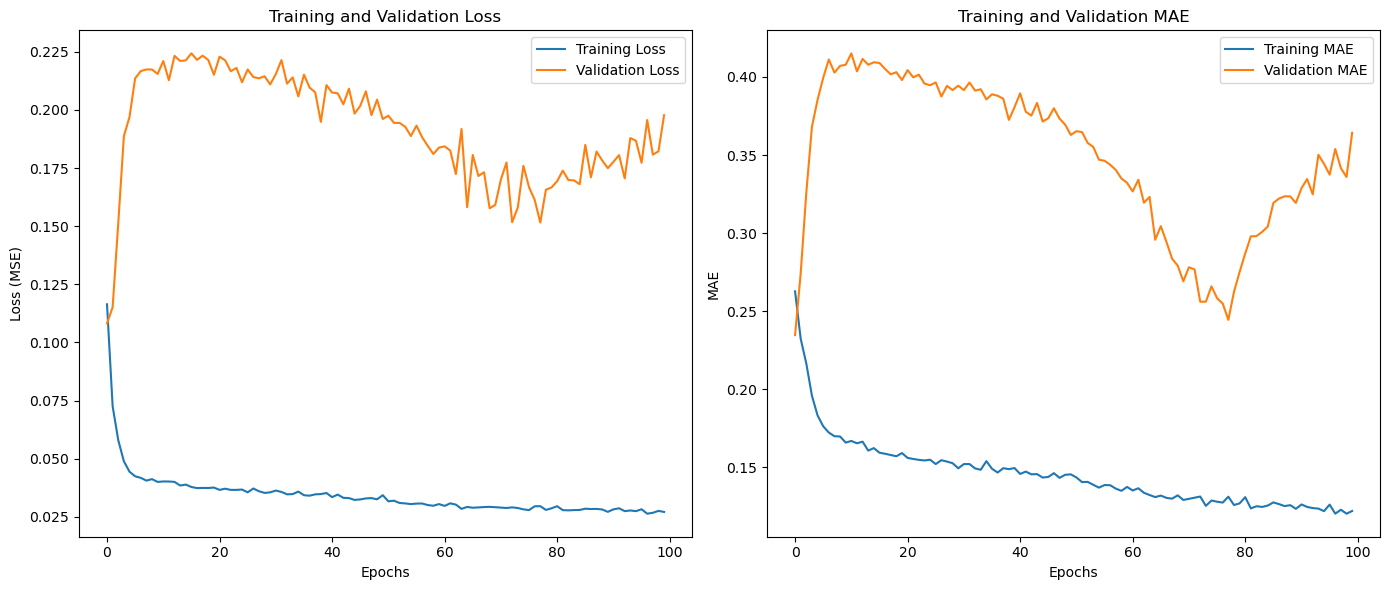

In [62]:
# Step 12: Plot the training and validation loss over epochs
plt.figure(figsize=(14, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot for MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
df_p_a=predicted_vs_actual.copy()

In [64]:
df_test=testdf.reset_index()

In [65]:
df_p_a['TWT'] = df_test['TWT']

In [66]:
df_p_a['TWT'] = df_test['TWT']

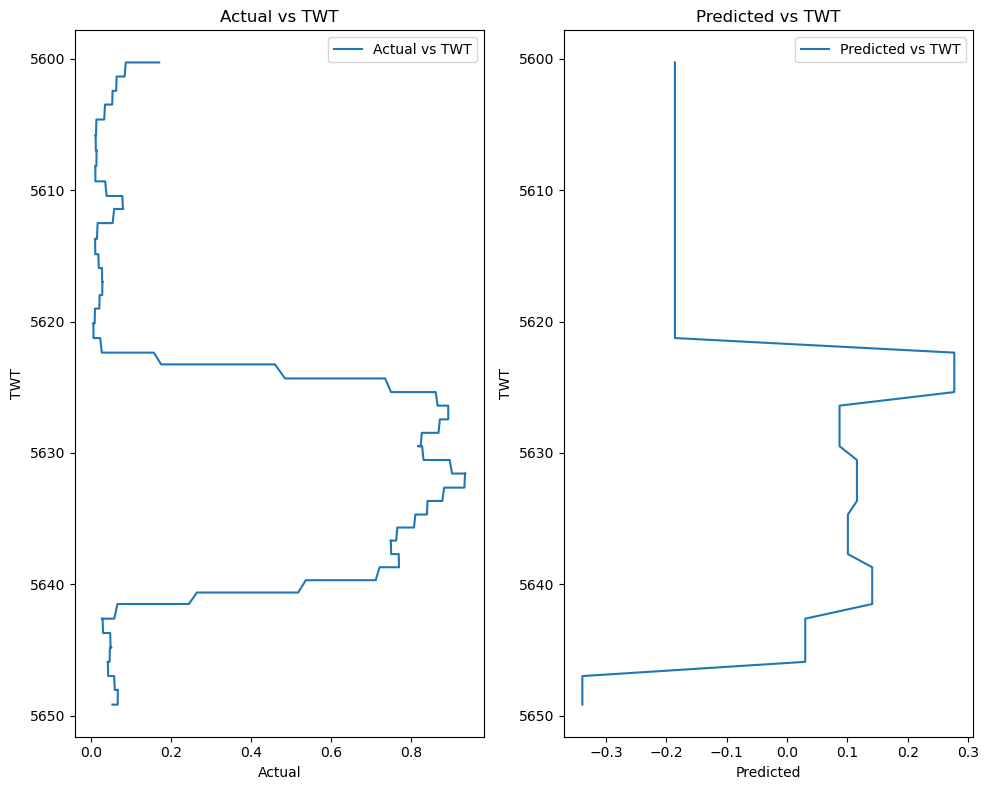

In [67]:
import matplotlib.pyplot as plt

# Create a figure with a 1x2 grid (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 8))  # Adjust figsize as needed

# Plot 1: Actual vs TWT
axs[0].plot(df_p_a['Actual'], df_p_a['TWT'], label='Actual vs TWT')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('TWT')
axs[0].set_title('Actual vs TWT')
axs[0].legend()
axs[0].invert_yaxis()

# Plot 2: Predicted vs TWT
axs[1].plot(df_p_a['Predicted'], df_p_a['TWT'], label='Predicted vs TWT')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('TWT')
axs[1].set_title('Predicted vs TWT')
axs[1].legend()
axs[1].invert_yaxis()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [68]:
# # Apply transformations (Seismic)
transformed_df_s = apply_transformations(df, features)

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [69]:
transformed_df_s.columns

Index(['Env_original', 'Env_sqrt', 'Env_log', 'Env_inverse', 'Env_inv_sq',
       'Env_square', 'Env_log_square', 'Env_sqrt_log', 'LFI_original',
       'LFI_sqrt', 'LFI_log', 'LFI_inverse', 'LFI_inv_sq', 'LFI_square',
       'LFI_log_square', 'LFI_sqrt_log', 'LR_original', 'LR_sqrt', 'LR_log',
       'LR_inverse', 'LR_inv_sq', 'LR_square', 'LR_log_square', 'LR_sqrt_log',
       'MR_original', 'MR_sqrt', 'MR_log', 'MR_inverse', 'MR_inv_sq',
       'MR_square', 'MR_log_square', 'MR_sqrt_log', 'PR_original', 'PR_sqrt',
       'PR_log', 'PR_inverse', 'PR_inv_sq', 'PR_square', 'PR_log_square',
       'PR_sqrt_log', 'VPVS_original', 'VPVS_sqrt', 'VPVS_log', 'VPVS_inverse',
       'VPVS_inv_sq', 'VPVS_square', 'VPVS_log_square', 'VPVS_sqrt_log',
       'ZP_original', 'ZP_sqrt', 'ZP_log', 'ZP_inverse', 'ZP_inv_sq',
       'ZP_square', 'ZP_log_square', 'ZP_sqrt_log', 'Sweetness_original',
       'Sweetness_sqrt', 'Sweetness_log', 'Sweetness_inverse',
       'Sweetness_inv_sq', 'Sweetness_squar

In [70]:
transformed_df_s1=transformed_df_s[['Env_original', 'Env_square',
       'Env_sqrt', 'Env_log_square', 'Env_log', 'Env_sqrt_log']]

In [71]:
# Fit and transform the training features
transformed_df_s1[columns_to_scale] = scaler.transform(transformed_df_s1[columns_to_scale])

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_960\565123183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df_s1[columns_to_scale] = scaler.transform(transformed_df_s1[columns_to_scale])


In [72]:
predict_seismic_o = model.predict(transformed_df_s1)

362731/362731 [==============================] - 346s 953us/step


In [73]:
df_seismic_Porosity=pd.DataFrame(predict_seismic_o).rename(columns={0:'PHIE'})

In [74]:
df_seismic_ppred = target_scaler.inverse_transform(df_seismic_Porosity[['PHIE']])

In [75]:
df_spp_f=pd.DataFrame(df_seismic_ppred).rename(columns={0:'PHIE_P'})

In [76]:
transformed_df_s_1=transformed_df_s.reset_index()

In [77]:
transformed_df_s_1

,index,Env_original,Env_sqrt,Env_log,Env_inverse,Env_inv_sq,Env_square,Env_log_square,Env_sqrt_log,LFI_original,...,ZP_log_square,ZP_sqrt_log,Sweetness_original,Sweetness_sqrt,Sweetness_log,Sweetness_inverse,Sweetness_inv_sq,Sweetness_square,Sweetness_log_square,Sweetness_sqrt_log
0,31,10378.794922,101.876371,9.247520,0.000096,9.283380e-09,1.077194e+08,85.516627,3.040974,2669.455811,...,0.396045,0.793298,8690.144531,93.220945,9.069945,0.000115,1.324177e-08,7.551861e+07,82.263900,3.011635
1,32,5972.958496,77.284918,8.694998,0.000167,2.802986e-08,3.567623e+07,75.602984,2.948728,2702.807129,...,0.398948,0.794747,8752.392578,93.554223,9.077082,0.000114,1.305408e-08,7.660438e+07,82.393425,3.012820
2,33,5861.380371,76.559652,8.676140,0.000171,2.910718e-08,3.435578e+07,75.275412,2.945529,2784.154785,...,0.430688,0.810104,8564.694336,92.545634,9.055404,0.000117,1.363252e-08,7.335399e+07,82.000337,3.009220
3,34,10305.414062,101.515585,9.240425,0.000097,9.416058e-09,1.062016e+08,85.385448,3.039807,2866.609863,...,0.455555,0.821552,8492.667969,92.155672,9.046958,0.000118,1.386474e-08,7.212541e+07,81.847458,3.007816
4,35,15006.782227,122.502172,9.616258,0.000067,4.440428e-09,2.252035e+08,92.472409,3.101009,2871.409424,...,0.449372,0.818750,8585.920898,92.660244,9.057879,0.000116,1.356520e-08,7.371804e+07,82.045173,3.009631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607373,14115431,33948.960938,184.252438,10.432614,0.000029,8.676549e-10,1.152532e+09,108.839425,3.229956,2973.063232,...,0.293698,0.736165,12228.258789,110.581458,9.411505,0.000082,6.687607e-09,1.495303e+08,88.576423,3.067818
11607374,14115432,24905.085938,157.813453,10.122827,0.000040,1.612219e-09,6.202633e+08,102.471633,3.181639,3171.263184,...,0.345306,0.766569,11478.899414,107.139626,9.348266,0.000087,7.589261e-09,1.317651e+08,87.390073,3.057493
11607375,14115433,6460.485352,80.377144,8.773460,0.000155,2.395906e-08,4.173787e+07,76.973596,2.962003,3145.726807,...,0.343906,0.765790,11413.789062,106.835336,9.342577,0.000088,7.676095e-09,1.302746e+08,87.283754,3.056563
11607376,14115434,11930.838867,109.228379,9.386882,0.000084,7.025189e-09,1.423449e+08,88.113550,3.063802,2918.729004,...,0.304716,0.742974,11623.428711,107.812006,9.360778,0.000086,7.401700e-09,1.351041e+08,87.624166,3.059539


In [79]:
transformed_df_s_1[['Seis_Porosity']]=df_spp_f[['PHIE_P']]

In [80]:
transformed_df_s_1f=transformed_df_s_1[['index', 'Seis_Porosity']]

In [81]:
transformed_df_s_1f['Seis_Porosity'].max()

996107392.0

In [82]:
df_s

,index,inline,xline,X,Y,TWT,Env,LFI,LR,MR,PR,VPVS,ZP,Sweetness
0,0.0,1835.0,5305.0,784895.44,8746196.48,5620.0,14931.391602,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1835.0,5305.0,784895.44,8746196.48,5624.0,9822.913086,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1835.0,5305.0,784895.44,8746196.48,5628.0,8046.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1835.0,5305.0,784895.44,8746196.48,5632.0,2572.332764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1835.0,5305.0,784895.44,8746196.48,5636.0,9715.355469,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14115456,14115456.0,2475.0,5665.0,786795.20,8758871.04,5844.0,34306.816406,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115457,14115457.0,2475.0,5665.0,786795.20,8758871.04,5848.0,37282.238281,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115458,14115458.0,2475.0,5665.0,786795.20,8758871.04,5852.0,35743.261719,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115459,14115459.0,2475.0,5665.0,786795.20,8758871.04,5856.0,29610.474609,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
transformed_df_s_1f=transformed_df_s_1f.rename(columns={'index':'Index'})

In [84]:
df_sa=df_s.rename(columns={'index':'Index'})

In [85]:
df_sa

,Index,inline,xline,X,Y,TWT,Env,LFI,LR,MR,PR,VPVS,ZP,Sweetness
0,0.0,1835.0,5305.0,784895.44,8746196.48,5620.0,14931.391602,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1835.0,5305.0,784895.44,8746196.48,5624.0,9822.913086,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1835.0,5305.0,784895.44,8746196.48,5628.0,8046.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1835.0,5305.0,784895.44,8746196.48,5632.0,2572.332764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1835.0,5305.0,784895.44,8746196.48,5636.0,9715.355469,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14115456,14115456.0,2475.0,5665.0,786795.20,8758871.04,5844.0,34306.816406,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115457,14115457.0,2475.0,5665.0,786795.20,8758871.04,5848.0,37282.238281,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115458,14115458.0,2475.0,5665.0,786795.20,8758871.04,5852.0,35743.261719,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14115459,14115459.0,2475.0,5665.0,786795.20,8758871.04,5856.0,29610.474609,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
df_sa=pd.merge(df_sa, transformed_df_s_1f, on=['Index'], how= 'left' ) 

In [87]:
df_sa

,Index,inline,xline,X,Y,TWT,Env,LFI,LR,MR,PR,VPVS,ZP,Sweetness,Seis_Porosity
0,0.0,1835.0,5305.0,784895.44,8746196.48,5620.0,14931.391602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,1835.0,5305.0,784895.44,8746196.48,5624.0,9822.913086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2.0,1835.0,5305.0,784895.44,8746196.48,5628.0,8046.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,3.0,1835.0,5305.0,784895.44,8746196.48,5632.0,2572.332764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,4.0,1835.0,5305.0,784895.44,8746196.48,5636.0,9715.355469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14115456,14115456.0,2475.0,5665.0,786795.20,8758871.04,5844.0,34306.816406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14115457,14115457.0,2475.0,5665.0,786795.20,8758871.04,5848.0,37282.238281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14115458,14115458.0,2475.0,5665.0,786795.20,8758871.04,5852.0,35743.261719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14115459,14115459.0,2475.0,5665.0,786795.20,8758871.04,5856.0,29610.474609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [88]:
df_sa['Seis_Porosity'] = df_sa['Seis_Porosity'].where((df_sa['Seis_Porosity'] >= 0) & (df_sa['Seis_Porosity'] <= 1), np.nan)

In [89]:
df_sa

,Index,inline,xline,X,Y,TWT,Env,LFI,LR,MR,PR,VPVS,ZP,Sweetness,Seis_Porosity
0,0.0,1835.0,5305.0,784895.44,8746196.48,5620.0,14931.391602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,1835.0,5305.0,784895.44,8746196.48,5624.0,9822.913086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2.0,1835.0,5305.0,784895.44,8746196.48,5628.0,8046.707031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,3.0,1835.0,5305.0,784895.44,8746196.48,5632.0,2572.332764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,4.0,1835.0,5305.0,784895.44,8746196.48,5636.0,9715.355469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14115456,14115456.0,2475.0,5665.0,786795.20,8758871.04,5844.0,34306.816406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14115457,14115457.0,2475.0,5665.0,786795.20,8758871.04,5848.0,37282.238281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14115458,14115458.0,2475.0,5665.0,786795.20,8758871.04,5852.0,35743.261719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14115459,14115459.0,2475.0,5665.0,786795.20,8758871.04,5856.0,29610.474609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [90]:
df_sat=df_sa.dropna()

Data post processing 

In [91]:
arr_data = np.array(df_sa)

In [94]:
def writesegy(attribute,arr_data,name):
    len_ilines = len(np.unique(arr_data[:,1]))
    len_xlines = len(np.unique(arr_data[:,2]))
    len_depth = len(np.unique(arr_data[:,5]))
    attribute_reshaped = attribute.reshape(len_ilines*len_xlines, len_depth)
    #start_time = time.time()
    

    spec = segyio.spec()
    file = name
    spec.format = 1
    spec.xline = 193
    spec.iline = 189
    spec.cdp_x = 181
    spec.cdp_y = 185
    spec.offsets = [0]
    spec.samples = np.unique(arr_data[:,5])
    spec.ilines = np.unique(arr_data[:,1])
    spec.xlines = np.unique(arr_data[:,2])
    cdp_x = arr_data[:,3]
    cdp_y = arr_data[:,4]
    cdpx = []
    cdpy = []
    for i in range(0,len(cdp_x),len(spec.samples)):
        cdpx.append(cdp_x[i])
        cdpy.append(cdp_y[i])

    with segyio.create(file, spec) as f:
        ix=(len_ilines*len_xlines)
        f.trace[:ix] = attribute_reshaped[:ix]
        hdx = 0      #writing on file header, like file.header[0], file.header[1]...
        for ilno in spec.ilines:
            for xlno in spec.xlines:
                f.header[hdx] = {segyio.TraceField.INLINE_3D: int(ilno),
                                 segyio.TraceField.CROSSLINE_3D: int(xlno),
                                 segyio.TraceField.CDP_X: int(cdpx[hdx]),
                                 segyio.TraceField.CDP_Y: int(cdpy[hdx]),
                                 segyio.TraceField.offset:0, 
                                 segyio.TraceField.SourceGroupScalar: 1,
                                segyio.TraceField.DelayRecordingTime: int(spec.samples[0])} #Source group scalar should be matched with the input volume
                hdx = hdx+1
writesegy(arr_data[:,8],arr_data,name='Seismic_Porosity_OVL3_gd.sgy')                